In [ ]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import k_means, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

# Data Gathering and Data Reading

In [ ]:
df1 = pd.read_csv("/content/drive/MyDrive/customer_segmentation.csv",encoding = 'latin-1')
df = df1.copy(deep=True)
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/2011 12:50,4.95,12680.0,France


# Data Preprocessing

In [ ]:
df.shape

(541909, 8)

In [ ]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df.isnull().mean()*100

,0
InvoiceNo,0.000000
StockCode,0.000000
Description,0.268311
Quantity,0.000000
InvoiceDate,0.000000
UnitPrice,0.000000
CustomerID,24.926694
Country,0.000000


In [ ]:
df.dropna(inplace = True, how = 'any')

In [ ]:
df.isnull().sum()


,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


In [ ]:
df['InvoiceDate'].iloc[0]

'12/1/2010 8:26'

In [ ]:
df.describe(include = 'all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,406829,406829,406829,406829.000000,406829,406829.000000,406829.000000,406829
unique,22190,3684,3896,NaN,20460,NaN,NaN,37
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,11/14/2011 15:27,NaN,NaN,United Kingdom
freq,542,2077,2070,NaN,543,NaN,NaN,361878
mean,NaN,NaN,NaN,12.061303,NaN,3.460471,15287.690570,NaN
std,NaN,NaN,NaN,248.693370,NaN,69.315162,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,0.000000,12346.000000,NaN
25%,NaN,NaN,NaN,2.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,5.000000,NaN,1.950000,15152.000000,NaN
75%,NaN,NaN,NaN,12.000000,NaN,3.750000,16791.000000,NaN


In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%Y %H:%M')

# Key Data Insights

In [ ]:
# 1. Country-wise Customer Distribution
df["Country"].value_counts().head()

,count
Country,
United Kingdom,361878
Germany,9495
France,8491
EIRE,7485
Spain,2533


Analyed the most active countries can help tailor marketing strategies and understand geographical demand.

In [ ]:
# High-Value Products
df.groupby("Description").agg({"UnitPrice":"max"}).sort_values("UnitPrice", ascending = False).head()

,UnitPrice
Description,
Manual,38970.00
POSTAGE,8142.75
Discount,1867.86
DOTCOM POSTAGE,1599.26
CRUK Commission,1100.44


Knowing which products are priced the highest can inform pricing strategies and inventory management.

In [ ]:
#High Revenue Generating Products
df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']
top_products = df.groupby('Description')['TotalRevenue'].sum().sort_values(ascending=False).head(10)
top_products

,TotalRevenue
Description,
REGENCY CAKESTAND 3 TIER,132870.40
WHITE HANGING HEART T-LIGHT HOLDER,93823.85
JUMBO BAG RED RETROSPOT,83236.76
PARTY BUNTING,67687.53
POSTAGE,66710.24
ASSORTED COLOUR BIRD ORNAMENT,56499.22
RABBIT NIGHT LIGHT,51137.80
CHILLI LIGHTS,45936.81
PAPER CHAIN KIT 50'S CHRISTMAS,41500.48


identified the top 10 products generating the most revenue. This insight can guide promotions and product focus.

In [ ]:
# Total Quantity Sold
df.groupby("Description").agg({"Quantity":"sum"}).head()

,Quantity
Description,
4 PURPLE FLOCK DINNER CANDLES,140
50'S CHRISTMAS GIFT BAG LARGE,1883
DOLLY GIRL BEAKER,2391
I LOVE LONDON MINI BACKPACK,360
I LOVE LONDON MINI RUCKSACK,1


the total quantity sold for each product description, which helps in inventory forecasting and understanding customer preferences.

In [ ]:
# Unique Invoices
df["InvoiceNo"].nunique()

22190

the unique invoice numbers, indicating the total number of transactions in the dataset. It's useful for understanding transaction volume.

In [ ]:
# First Invoice Date
df['InvoiceDate'].iloc[0]

Timestamp('2010-12-01 08:26:00')

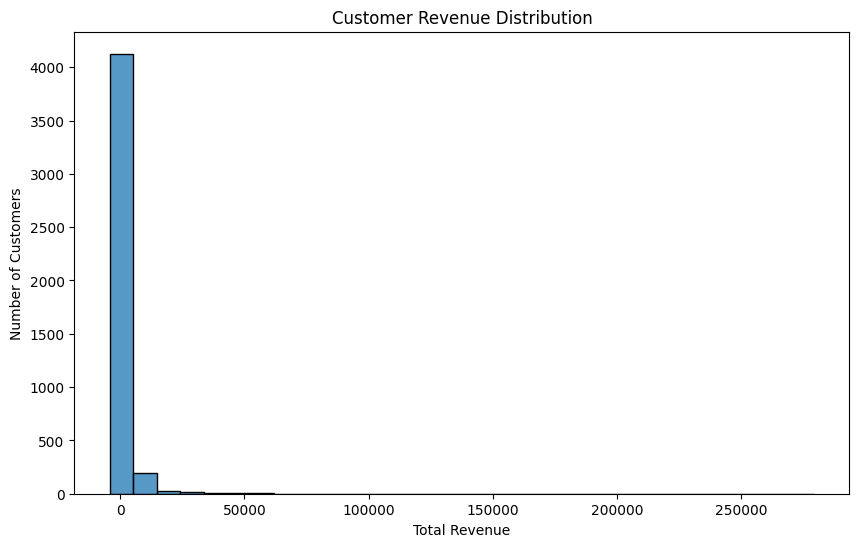

In [ ]:

#total revenue per customer
customer_revenue = df.groupby('CustomerID')['TotalRevenue'].sum()

#purchase frequency per customer
purchase_frequency = df.groupby('CustomerID')['InvoiceNo'].count()

#average order value per customer
average_order_value = customer_revenue / purchase_frequency

# purchase patterns over time
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_revenue = df.groupby('InvoiceMonth')['TotalRevenue'].sum()


# Visualize customer revenue distribution
plt.figure(figsize=(10, 6))
sns.histplot(customer_revenue, bins=30)
plt.title('Customer Revenue Distribution')
plt.xlabel('Total Revenue')
plt.ylabel('Number of Customers')
plt.show()


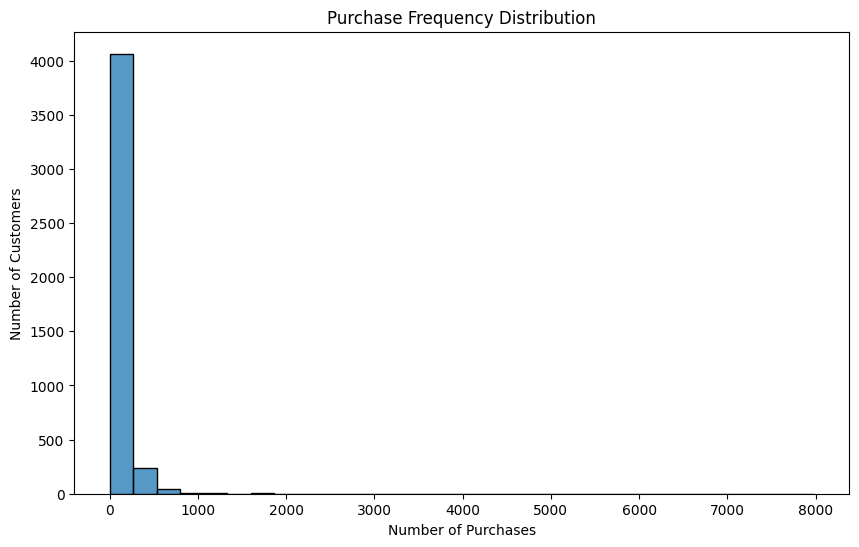

In [ ]:

# Visualize purchase frequency distribution
plt.figure(figsize=(10, 6))
sns.histplot(purchase_frequency, bins=30)
plt.title('Purchase Frequency Distribution')
plt.xlabel('Number of Purchases')
plt.ylabel('Number of Customers')
plt.show()



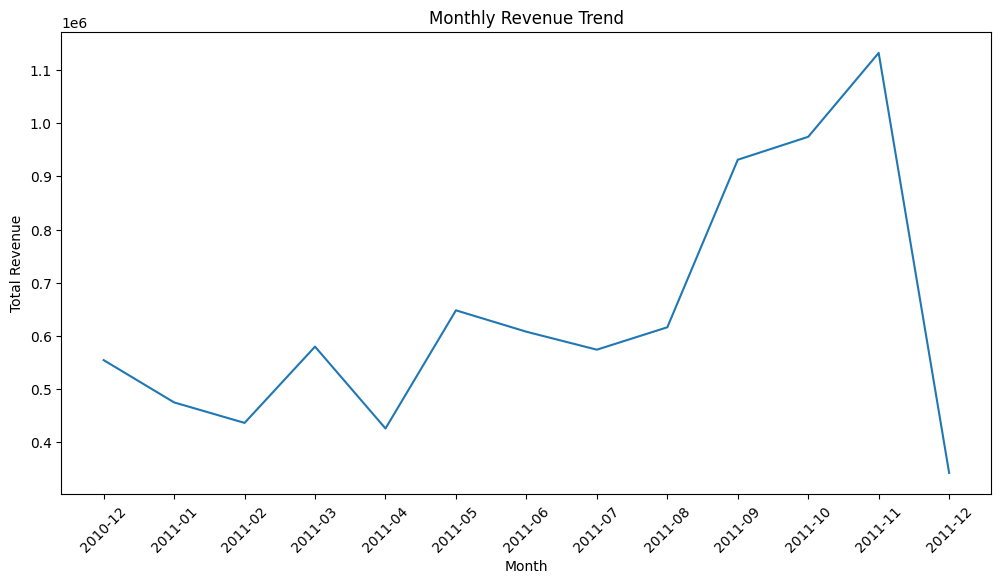

In [ ]:
# Visualize monthly revenue trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_revenue.index.astype(str), monthly_revenue.values)
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()


This line chart shows revenue trends over time, useful for identifying seasonal patterns.

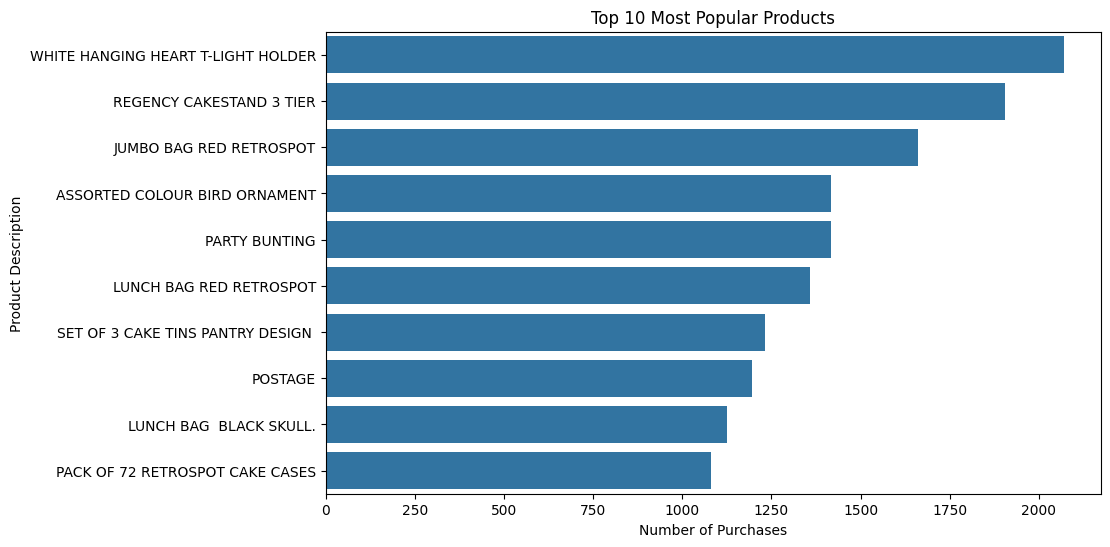

In [ ]:
# Analyze product popularity
product_popularity = df['Description'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=product_popularity.values, y=product_popularity.index)
plt.title('Top 10 Most Popular Products')
plt.xlabel('Number of Purchases')
plt.ylabel('Product Description')
plt.show()


This bar chart highlights the most purchased products, which can inform stock and marketing decisions.


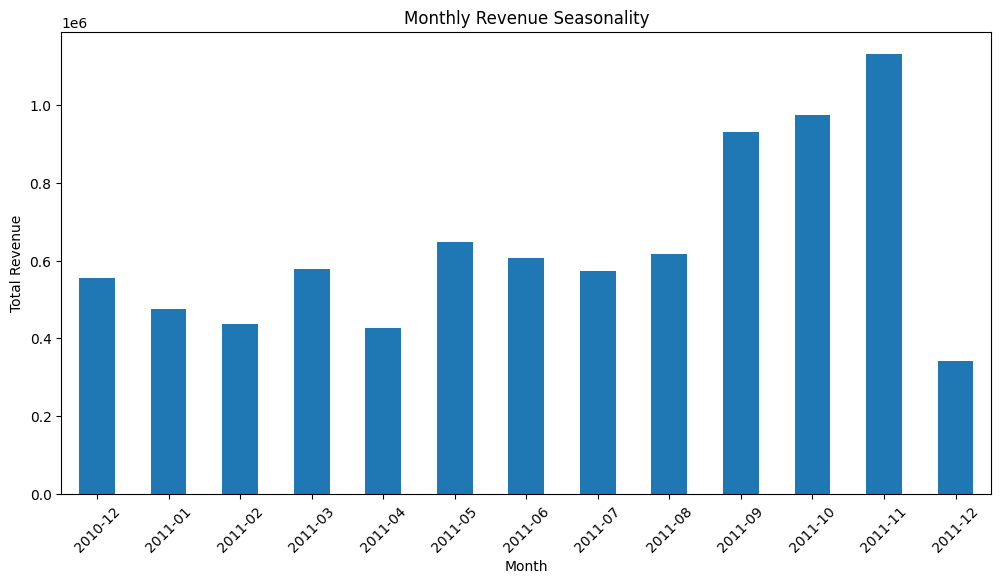

In [ ]:
# Analyze sales seasonality using monthly revenue data
plt.figure(figsize=(12, 6))
monthly_revenue.plot(kind='bar')
plt.title('Monthly Revenue Seasonality')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.show()

This bar chart shows revenue distribution across months, indicating seasonal sales trends.

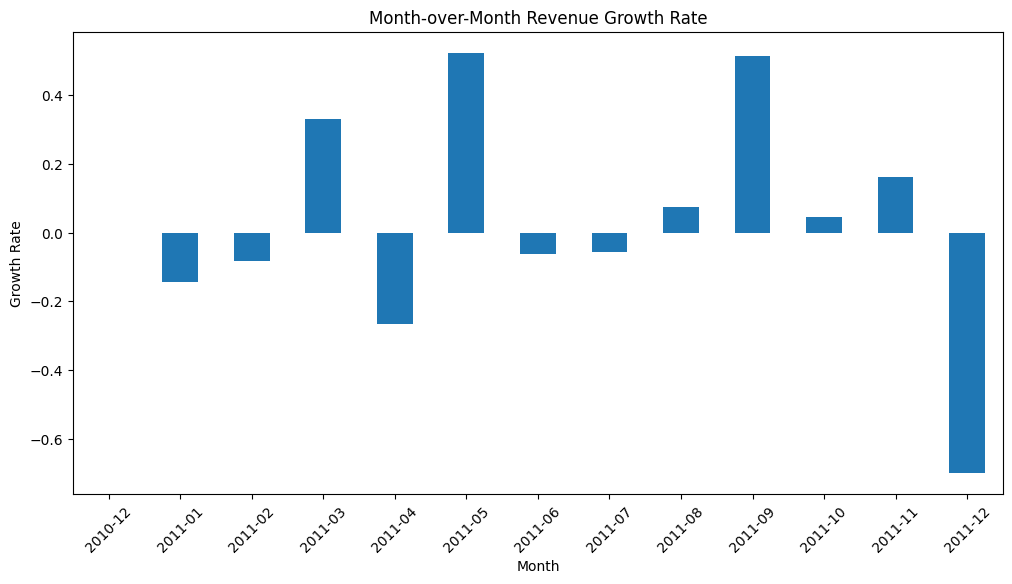

In [ ]:
# Calculate and visualize the month-over-month revenue growth rate
monthly_revenue_growth = monthly_revenue.pct_change()
plt.figure(figsize=(12, 6))
monthly_revenue_growth.plot(kind='bar')
plt.title('Month-over-Month Revenue Growth Rate')
plt.xlabel('Month')
plt.ylabel('Growth Rate')
plt.xticks(rotation=45)
plt.show()

This bar chart displays revenue growth rates month-over-month, providing insights into the business's financial health.

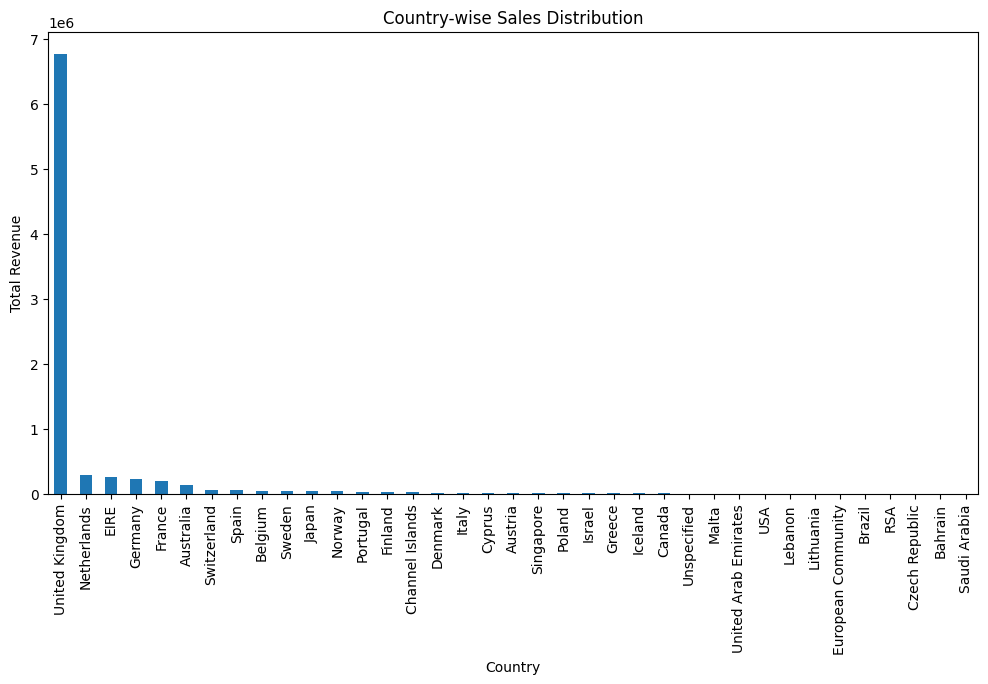

In [ ]:
# Country-wise Sales Distribution
country_sales = df.groupby('Country')['TotalRevenue'].sum().sort_values(ascending=False)

# Visualize country-wise sales distribution
plt.figure(figsize=(12, 6))
country_sales.plot(kind='bar')
plt.title('Country-wise Sales Distribution')
plt.xlabel('Country')
plt.ylabel('Total Revenue')
plt.xticks(rotation=90)
plt.show()

This bar chart shows sales by country, highlighting geographical strengths and areas for improvement.

# Feature Engineering

In [ ]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue,InvoiceMonth,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,20.34


# RFM Analysis

In [ ]:
reference_date = pd.Timestamp(max(df['InvoiceDate'])) + dt.timedelta(days=1)
reference_date


Timestamp('2011-12-10 12:50:00')

In [ ]:
rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda InvoiceDate: (reference_date - InvoiceDate.max()).days,
                                     'InvoiceNo': 'count',
                                     'TotalPrice': 'sum'})
rfm.head()

,InvoiceDate,InvoiceNo,TotalPrice
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [ ]:
rfm.rename(columns = {'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalPrice':'Value'})

,Recency,Frequency,Value
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,13,176.60


In [ ]:
rfm.rename(columns = {'InvoiceDate':'Recency','InvoiceNo':'Frequency','TotalPrice':'Value'}, inplace=True)

In [ ]:
quantiles = rfm.quantile(q=[0.25,0.50,0.75])

def RScore(x, p, d):
  if p == 'Recency':

    if x <= d[p][0.25]:
      return 4
    elif x <= d[p][0.50]:
      return 3
    elif x <= d[p][0.75]:
      return 2
    else:
      return 1
  else:
    if x <= d[p][0.25]:
      return 1
    elif x <= d[p][0.50]:
      return 2
    elif x <= d[p][0.75]:
      return 3
    else:
      return 4

rfm['R'] = rfm['Recency'].apply(RScore, args=('Recency',quantiles))
rfm['F'] = rfm['Frequency'].apply(RScore, args=('Frequency',quantiles))
rfm['M'] = rfm['Value'].apply(RScore, args=('Value',quantiles))
rfm.head()

,Recency,Frequency,Value,R,F,M
CustomerID,,,,,,
12346.0,326,2,0.00,1,1,1
12347.0,2,182,4310.00,4,4,4
12348.0,75,31,1797.24,2,2,4
12349.0,19,73,1757.55,3,3,4
12350.0,310,17,334.40,1,1,2


In [ ]:
rfm['RFM_Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm['RFM_Score'] = rfm[['R','F','M']].sum(axis=1)
rfm.head()

,Recency,Frequency,Value,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3
12347.0,2,182,4310.00,4,4,4,444,12
12348.0,75,31,1797.24,2,2,4,224,8
12349.0,19,73,1757.55,3,3,4,334,10
12350.0,310,17,334.40,1,1,2,112,4


In [ ]:
rfm['RFM_Score'].describe()

,RFM_Score
count,4372.000000
mean,7.501601
std,2.828144
min,3.000000
25%,5.000000
50%,7.000000
75%,10.000000
max,12.000000


segmented the customer based on the behaviour this can be moved to the marketing department
111 - not frequent customer
444 - Loyal Customers

In [ ]:
segment_labels = ['Low-Value', 'Mid-Value', 'High-Value']

In [ ]:
def assign_segment(score):
  if score < 5:
    return 'Low Value'
  elif score <9:
    return 'Mid Value'
  else:
    return 'High Value'

rfm['RFM_Segment_Label'] = rfm['RFM_Score'].apply(assign_segment)
rfm.head()

,Recency,Frequency,Value,R,F,M,RFM_Segment,RFM_Score,RFM_Segment_Label
CustomerID,,,,,,,,,
12346.0,326,2,0.00,1,1,1,111,3,Low Value
12347.0,2,182,4310.00,4,4,4,444,12,High Value
12348.0,75,31,1797.24,2,2,4,224,8,Mid Value
12349.0,19,73,1757.55,3,3,4,334,10,High Value
12350.0,310,17,334.40,1,1,2,112,4,Low Value


In [ ]:
segment_count = rfm['RFM_Segment_Label'].value_counts().reset_index()
segment_count.columns = ['RFM_Segment', 'Count']
segment_count = segment_count.sort_values('RFM_Segment')

In [ ]:
import plotly.express as px
fig = px.bar(segment_count,
             x='RFM_Segment',
             y='Count',
             title='Count of Customers by RFM Segment',
             labels = {'RFM_Segment':'RFM Segment','Count':'Count of Customers'},
             color = 'RFM_Segment',
             color_discrete_sequence = px.colors.qualitative.Pastel,
             text='Count')
fig.show()

*   **Loyal Customers** - Highly Engage They
spend a lot
*   **Potentially Loyal Customer** - this category has a moderate rfm score these customer have a potential to reach the Loyal Customer Status
*   **At Risk** - They have a possibility to churn if we dont re- engage them back
*   **Can't Loose** - they have very low rfm score - they indicate they are very close to be lost
    *   *if we lose this segment there will be a lost to the company
for this segment try to engage them so that they make a purchase and we can retain them*




In [ ]:
rfm['RFM_Customer_Segments'] = ''


In [ ]:
rfm['RFM_Customer_Segments'] = ''

rfm.loc[(rfm['RFM_Score'] >= 9), 'RFM_Customer_Segments'] = 'LoyalCustomers'  # High value
rfm.loc[(rfm['RFM_Score'] >= 6) & (rfm['RFM_Score'] < 9), 'RFM_Customer_Segments'] = 'Potential Loyalists'  # Mid value
rfm.loc[(rfm['RFM_Score'] >= 5) & (rfm['RFM_Score'] < 6), 'RFM_Customer_Segments'] = 'At Risk Customers'  # Mid value
rfm.loc[(rfm['RFM_Score'] >= 4) & (rfm['RFM_Score'] < 5), 'RFM_Customer_Segments'] = "Can't Lose Them"  # Low value
rfm.loc[(rfm['RFM_Score'] >= 3) & (rfm['RFM_Score'] < 4), 'RFM_Customer_Segments'] = 'Lost Customers'  # Low value

segment_count = rfm['RFM_Customer_Segments'].value_counts().sort_index()
segment_count


,count
RFM_Customer_Segments,
At Risk Customers,517
Can't Lose Them,391
Lost Customers,392
LoyalCustomers,1690
Potential Loyalists,1382


In [ ]:
segment_product_count = rfm.groupby(['RFM_Segment_Label', 'RFM_Customer_Segments']).size().reset_index(name='Count')

segment_product_count = segment_product_count.sort_values('Count', ascending=False)


In [ ]:
fig_treemap_segment = px.treemap(segment_product_count,
                                path=['RFM_Segment_Label', 'RFM_Customer_Segments'],
                                 values = 'Count',
                                 color = 'RFM_Segment_Label',
                                 color_discrete_sequence = px.colors.qualitative.Pastel,
                                 title = 'Segment Treemap')
fig_treemap_segment.update_traces(texttemplate='%{label}<br>Count: %{value}', textinfo='label+text')
fig_treemap_segment.show()

In [ ]:
rfm.to_csv('rfm_analysis.csv')

# Clustering Analysis

In [ ]:
# Select only the numerical columns for scaling
rfm_values = rfm[['Recency', 'Frequency', 'Value']]



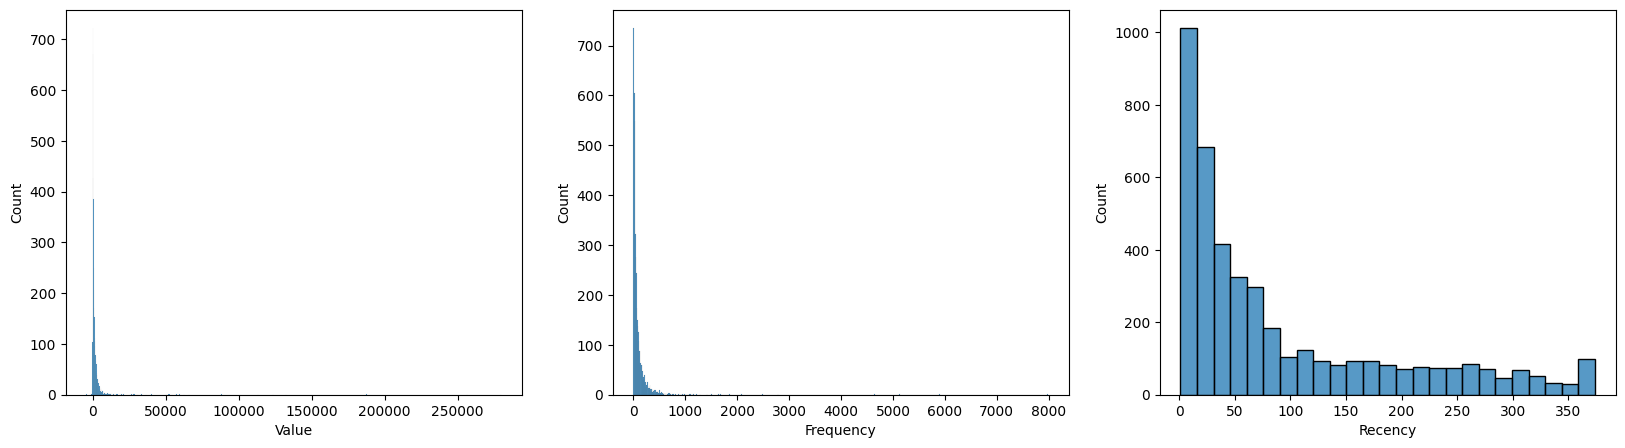

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
sns.histplot(rfm['Value'])
plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'])
plt.subplot(1, 3, 3)
sns.histplot(rfm['Recency'])
plt.show(block=True)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler().fit_transform(rfm_values)
rfm_cluster_scaled = pd.DataFrame(mms, columns=['Recency', 'Frequency', 'Value'], index=rfm.index)
rfm_cluster_scaled.head()

,Recency,Frequency,Value
CustomerID,,,
12346.0,0.871314,0.000125,0.015109
12347.0,0.002681,0.022676,0.030297
12348.0,0.198391,0.003758,0.021442
12349.0,0.048257,0.009020,0.021303
12350.0,0.828418,0.002005,0.016288


In [ ]:
rfm_cluster_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4372.0,0.244094,0.270149,0.0,0.042895,0.131367,0.380697,1.0
Frequency,4372.0,0.011533,0.029124,0.0,0.002005,0.005137,0.012653,1.0
Value,4372.0,0.021799,0.028964,0.0,0.016143,0.017393,0.020789,1.0


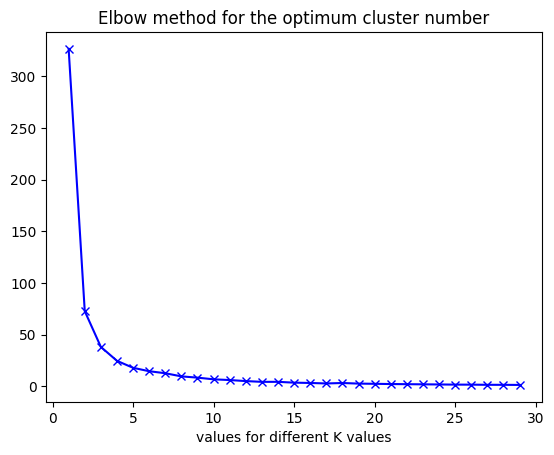

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
kmeans = KMeans()
ssd = []
K = range(1, 30)
for k in K:
    kmeans = KMeans(n_clusters=k).fit(rfm_cluster_scaled)
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, 'bx-')
plt.xlabel('values for different K values')
plt.title('Elbow method for the optimum cluster number')
plt.show(block=True)

In [ ]:
silhouette_score_list = []
for i in range(2, 10):
    kmeans.fit(rfm_cluster_scaled)
    silhouette_score_list.append(silhouette_score(rfm_cluster_scaled, kmeans.labels_))
    print(silhouette_score_list)

[0.44843972830674306]
[0.44843972830674306, 0.42271293288089734]
[0.44843972830674306, 0.42271293288089734, 0.4526555490320086]
[0.44843972830674306, 0.42271293288089734, 0.4526555490320086, 0.4239045296309696]
[0.44843972830674306, 0.42271293288089734, 0.4526555490320086, 0.4239045296309696, 0.4187487728689614]
[0.44843972830674306, 0.42271293288089734, 0.4526555490320086, 0.4239045296309696, 0.4187487728689614, 0.44539397376228756]
[0.44843972830674306, 0.42271293288089734, 0.4526555490320086, 0.4239045296309696, 0.4187487728689614, 0.44539397376228756, 0.4186654570569884]
[0.44843972830674306, 0.42271293288089734, 0.4526555490320086, 0.4239045296309696, 0.4187487728689614, 0.44539397376228756, 0.4186654570569884, 0.447286527127792]


In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=300)
kmeans.fit(rfm_cluster_scaled)
pred = kmeans.predict(rfm_cluster_scaled)

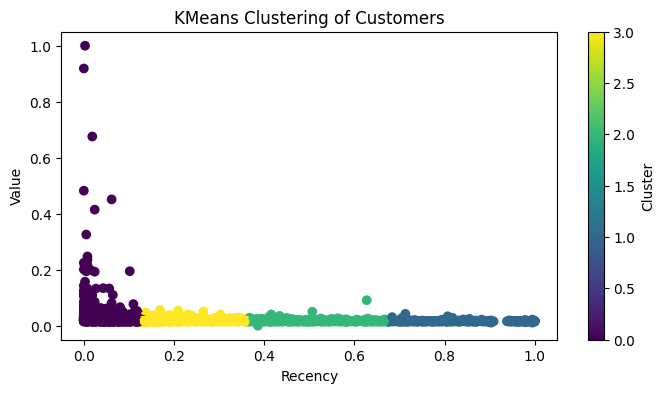

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(rfm_cluster_scaled['Recency'], rfm_cluster_scaled['Value'], c=pred, cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Value')
plt.title('KMeans Clustering of Customers')
plt.colorbar(label='Cluster')
plt.show()

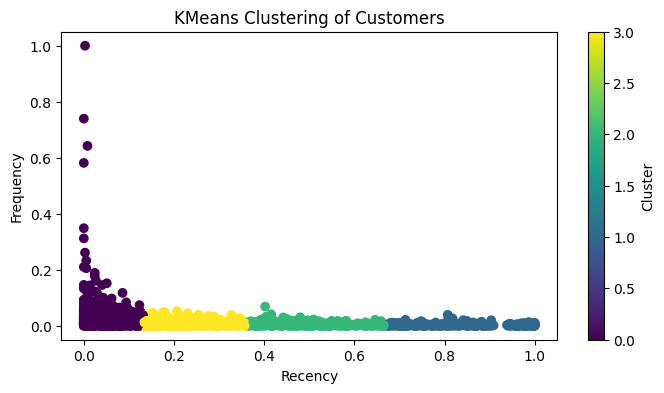

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(rfm_cluster_scaled['Recency'], rfm_cluster_scaled['Frequency'], c=pred, cmap='viridis')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('KMeans Clustering of Customers')
plt.colorbar(label='Cluster')
plt.show()

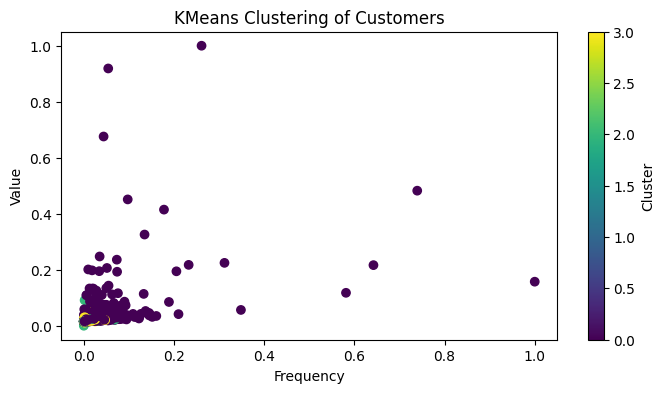

In [ ]:
plt.figure(figsize=(8,4))
plt.scatter(rfm_cluster_scaled['Frequency'], rfm_cluster_scaled['Value'], c=pred, cmap='viridis')
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.title('KMeans Clustering of Customers')
plt.colorbar(label='Cluster')
plt.show()

In [ ]:
df_rfm = pd.DataFrame(rfm)
df_rfm['cluster'] = pred
df_rfm['cluster'] = df_rfm['cluster'] + 1
df_rfm.head()
df_rfm.to_csv('rfm_analysis_with_kmeanscluster.csv')



*   Cluster 1:
  *   This Cluster consists of a diverse mix of customers, including high-value, loyal individuals who purchase frequently and spend significantly (e.g., RFM codes 114, 124, 144) as well as at-risk high spenders (e.g., 244, 224) who haven’t purchased recently. It also includes moderately engaged buyers with potential for growth and occasional buyers who require nurturing to increase their frequency and spending. Some customers are at risk of lapsing. To maximize value, prioritize loyalty programs for high-value customers, run reactivation campaigns for at-risk customers, and target promotions to increase engagement from moderate and low-value segments.

*   Cluster 2:
     *   Cluster 2 consists of customers with varied engagement levels, including those who haven't purchased recently but have moderate or high frequency and monetary values (e.g., RFM codes 213, 214, 224). This group also includes potential churners who were once valuable but now have low recency and decreasing frequency (e.g., 244, 234). Additionally, some customers show moderate recency and frequency with opportunities for upselling (e.g., 312, 321). Overall, Cluster 2 includes customers who may need re-engagement strategies like personalized offers or loyalty incentives to regain their interest and boost their spending behavior.

*   Cluster 3:
     * Cluster 3 is composed of high-value customers who are deeply engaged and loyal. They have made recent purchases (with low recency scores like 1 and 2), consistently frequent transactions (frequency scores mostly at 1 and 2), and tend to have significant monetary contributions (with monetary scores predominantly at 3 and 4). These customers (e.g., RFM codes 111, 112, 114, 144) represent a core group that consistently generates revenue. and should be prioritized for relationship-building strategies, such as VIP programs, exclusive offers, or early access to promotions to maintain their loyalty and maximize their lifetime value.




*   Cluster 4:
     * Cluster 4 consists of high-frequency customers who have relatively higher spending but show lower recent engagement. The recency scores range from 3 to 4, indicating these customers have not made purchases very recently. However, their frequency scores range from 1 to 4, and their monetary values also span from moderate to high (1 to 4). This suggests that these customers were highly engaged in the past and made significant purchases. They are valuable for retention strategies, and businesses should focus on re-engaging them through personalized offers, loyalty programs, or promotional incentives to encourage them to return.  



In [ ]:
df_rfm['cluster'].unique()

array([2, 1, 4, 3], dtype=int32)

In [ ]:
df_rfm[['cluster', 'Recency', 'Frequency', 'Value']].groupby('cluster').agg(['mean', 'count'])

Recency         Frequency              Value      
               mean count        mean count         mean count
cluster                                                       
1         18.524931  2166  146.072484  2166  3092.254077  2166
2        309.851779   506   23.217391   506   359.771245   506
3        190.451356   627   34.874003   627   587.371341   627
4         80.248835  1073   52.956198  1073   980.351726  1073

In [ ]:
import plotly.express as px
fig = px.scatter_3d(df_rfm, x='Recency', y='Frequency', z='Value', color='cluster',
                    title='Customer Segmentation based on RFM values',
                    labels={'Recency': 'Recency', 'Frequency': 'Frequency', 'Value': 'Value', 'cluster': 'Cluster'})
fig.show()

In [ ]:
rfm_df = pd.read_csv('rfm_analysis_with_kmeanscluster.csv')
# merged_df = pd.merge(df1, rfm_df, on='CustomerID', how='left')
# print(merged_df.head())
rfm_df.head()

,CustomerID,Recency,Frequency,Value,R,F,M,RFM_Segment,RFM_Score,RFM_Segment_Label,RFM_Customer_Segments,cluster
0,12346.0,326,2,0.00,1,1,1,111,3,Low Value,Lost Customers,2
1,12347.0,2,182,4310.00,4,4,4,444,12,High Value,LoyalCustomers,1
2,12348.0,75,31,1797.24,2,2,4,224,8,Mid Value,Potential Loyalists,4
3,12349.0,19,73,1757.55,3,3,4,334,10,High Value,LoyalCustomers,1
4,12350.0,310,17,334.40,1,1,2,112,4,Low Value,Can't Lose Them,2


In [ ]:
df_with_clusters = pd.read_csv('/content/rfm_analysis_with_kmeanscluster.csv')

In [ ]:
df_with_clusters.head()

,CustomerID,Recency,Frequency,Value,R,F,M,RFM_Segment,RFM_Score,RFM_Segment_Label,RFM_Customer_Segments,cluster
0,12346.0,326,2,0.00,1,1,1,111,3,Low Value,Lost Customers,2
1,12347.0,2,182,4310.00,4,4,4,444,12,High Value,LoyalCustomers,1
2,12348.0,75,31,1797.24,2,2,4,224,8,Mid Value,Potential Loyalists,4
3,12349.0,19,73,1757.55,3,3,4,334,10,High Value,LoyalCustomers,1
4,12350.0,310,17,334.40,1,1,2,112,4,Low Value,Can't Lose Them,2


# DBSCAN

In [ ]:
rfm_values = rfm[['Recency', 'Frequency', 'Value']]
scaler = StandardScaler()
scaled_rfm = scaler.fit_transform(rfm_values)

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)

In [ ]:
df_with_clusters['Clusterdcscan'] = dbscan.fit_predict(scaled_rfm)

In [ ]:
# Mark noise points (DBSCAN assigns -1 to noise points)
df_with_clusters['Clusterdcscan'] = df_with_clusters['Clusterdcscan'].apply(lambda x: 'Noise' if x == -1 else f'Cluster {x}')


In [ ]:
df_with_clusters['Clusterdcscan'].unique()

array(['Cluster 0', 'Noise', 'Cluster 2', 'Cluster 1'], dtype=object)

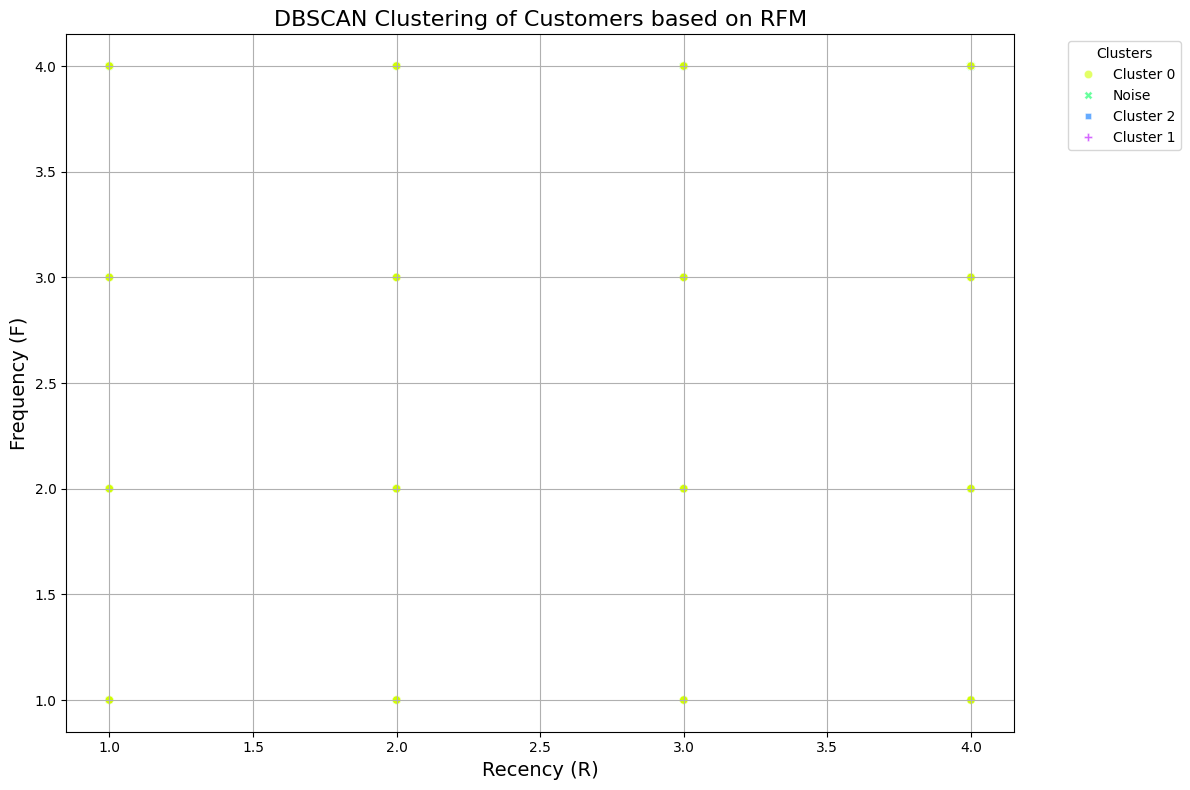

In [ ]:
def visualize_clusters():
    plt.figure(figsize=(12, 8))
    palette = sns.color_palette("hsv", len(df_with_clusters['Clusterdcscan'].unique()))

    sns.scatterplot(data=df_with_clusters, x='R', y='M', hue='Clusterdcscan', palette=palette, style='Clusterdcscan', alpha=0.6)
    plt.title('DBSCAN Clustering of Customers based on RFM', fontsize=16)
    plt.xlabel('Recency (R)', fontsize=14)
    plt.ylabel('Frequency (F)', fontsize=14)
    plt.legend(title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()
    plt.show()

visualize_clusters()

# Hierarcial Clustering


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
linked = linkage(scaled_rfm, method='ward')

In [ ]:
def plot_dendrogram():
    plt.figure(figsize=(12, 8))
    dendrogram(linked,
               orientation='top',
               labels=df_with_clusters['CustomerID'].astype(str).values,
               distance_sort='descending',
               show_leaf_counts=True)

    plt.title('Hierarchical Clustering Dendrogram', fontsize=16)
    plt.xlabel('Customer ID', fontsize=14)
    plt.ylabel('Distance', fontsize=14)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

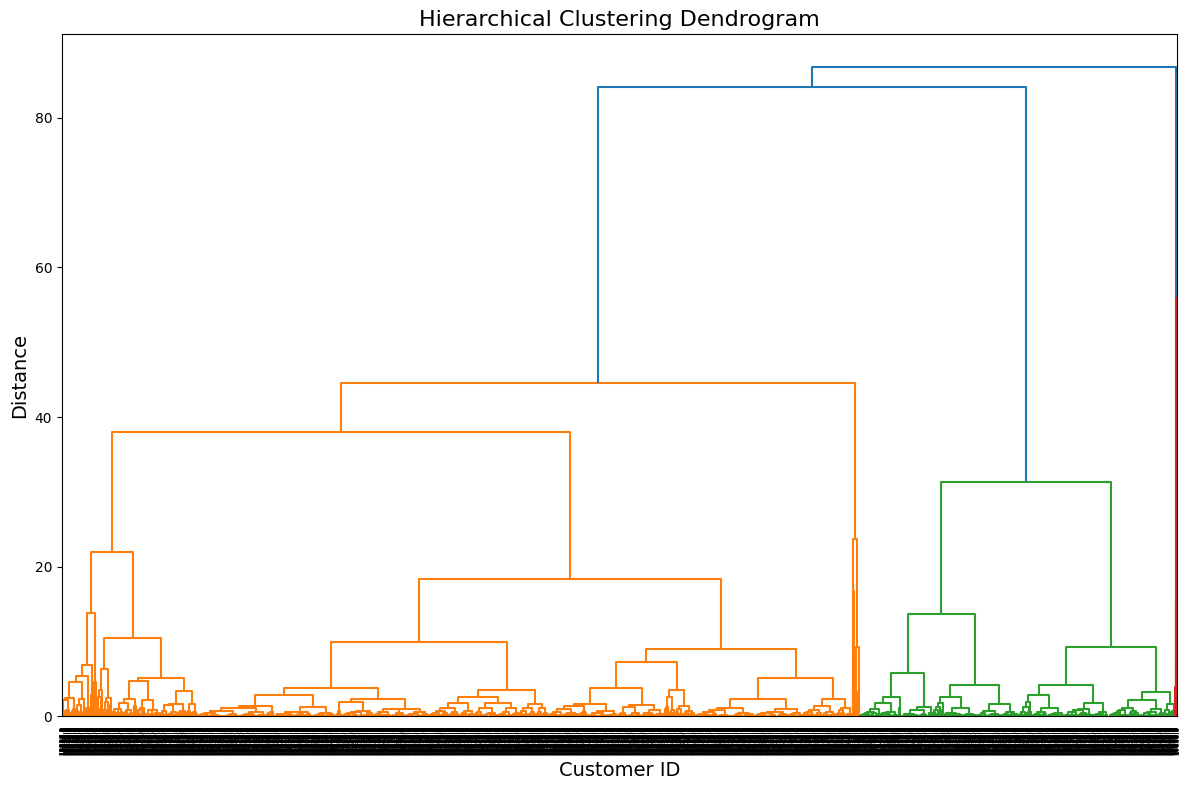

In [ ]:
plot_dendrogram()


In [ ]:
df_with_clusters.to_csv('Customer_Segmented_And_Clustered_Data.csv', index=False)

In [ ]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [ ]:
merged_df = pd.merge(df, df_with_clusters, on='CustomerID', how='inner')

columns_to_keep = ['InvoiceNo','InvoiceDate','CustomerID', 'Description','Country','UnitPrice', 'Quantity','R', 'F', 'M', 'RFM_Segment_Label','Recency','Frequency','Value' ,'RFM_Score', 'RFM_Segment', 'RFM_Customer_Segments', 'cluster','Clusterdcscan']
final_df = merged_df[columns_to_keep]

final_df.to_csv('Customer_data.csv', index=False)

In [ ]:
cd = pd.read_csv('/content/Customer_data.csv')
cd.head()

,InvoiceNo,InvoiceDate,CustomerID,Description,Country,UnitPrice,Quantity,R,F,M,RFM_Segment_Label,Recency,Frequency,Value,RFM_Score,RFM_Segment,RFM_Customer_Segments,cluster,Clusterdcscan
0,536365,2010-12-01 08:26:00,17850.0,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,2.55,6,1,4,4,High Value,302,312,5288.63,9,144,LoyalCustomers,2,Cluster 0
1,536365,2010-12-01 08:26:00,17850.0,WHITE METAL LANTERN,United Kingdom,3.39,6,1,4,4,High Value,302,312,5288.63,9,144,LoyalCustomers,2,Cluster 0
2,536365,2010-12-01 08:26:00,17850.0,CREAM CUPID HEARTS COAT HANGER,United Kingdom,2.75,8,1,4,4,High Value,302,312,5288.63,9,144,LoyalCustomers,2,Cluster 0
3,536365,2010-12-01 08:26:00,17850.0,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom,3.39,6,1,4,4,High Value,302,312,5288.63,9,144,LoyalCustomers,2,Cluster 0
4,536365,2010-12-01 08:26:00,17850.0,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom,3.39,6,1,4,4,High Value,302,312,5288.63,9,144,LoyalCustomers,2,Cluster 0


In [ ]:
from google.colab import files
files.download('Customer_data.csv')
#already downloaded if need - uncomment

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Churn Prediction

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

In [ ]:
data = pd.read_csv('/content/rfm_analysis.csv')
data.head()


,CustomerID,Recency,Frequency,Value,R,F,M,RFM_Segment,RFM_Score,RFM_Segment_Label,RFM_Customer_Segments
0,12346.0,326,2,0.00,1,1,1,111,3,Low Value,Lost Customers
1,12347.0,2,182,4310.00,4,4,4,444,12,High Value,LoyalCustomers
2,12348.0,75,31,1797.24,2,2,4,224,8,Mid Value,Potential Loyalists
3,12349.0,19,73,1757.55,3,3,4,334,10,High Value,LoyalCustomers
4,12350.0,310,17,334.40,1,1,2,112,4,Low Value,Can't Lose Them


In [ ]:
data['Churn'] = data['R'].apply(lambda x: 1 if x > 3 else 0)

In [ ]:
data.head()

,CustomerID,Recency,Frequency,Value,R,F,M,RFM_Segment,RFM_Score,RFM_Segment_Label,RFM_Customer_Segments,Churn
0,12346.0,326,2,0.00,1,1,1,111,3,Low Value,Lost Customers,0
1,12347.0,2,182,4310.00,4,4,4,444,12,High Value,LoyalCustomers,1
2,12348.0,75,31,1797.24,2,2,4,224,8,Mid Value,Potential Loyalists,0
3,12349.0,19,73,1757.55,3,3,4,334,10,High Value,LoyalCustomers,0
4,12350.0,310,17,334.40,1,1,2,112,4,Low Value,Can't Lose Them,0


In [ ]:
high_risk= 3
low_risk = 1


def assign_risk_category(row):
  if row['R'] > high_risk_threshold:
    return 'High Risk'
  elif row['R'] <= low_risk_threshold:
    return 'Low Risk'
  else:
    return 'Medium Risk'

data['Risk_Category'] = data.apply(assign_risk_category, axis=1)



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


X = data[['R', 'F', 'M', 'Risk_Category']] # Include 'Risk_Category' as a feature
y = data['Churn']

X = pd.get_dummies(X, columns=['Risk_Category'], prefix='Risk')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       976
           1       1.00      1.00      1.00       336

    accuracy                           1.00      1312
   macro avg       1.00      1.00      1.00      1312
weighted avg       1.00      1.00      1.00      1312



***Actionable Insights***
*  After identifying the customers likely to churn, businesses can:

    * Target with retention campaigns.
    * Provide personalized offers based on their past behavior.
    * Improve customer engagement with loyalty programs, discounts, or exclusive offers for high-value or frequent customers at risk of churn.

# Deployment

In [ ]:
# prompt: install gradio
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 287.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.4/447.4 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2

In [ ]:
import gradio as gr
import pandas as pd
from sklearn.ensemble import RandomForestClassifier


In [ ]:
def predict_churn(recency, frequency, monetary):
    try:
        recency = float(recency)
        frequency = float(frequency)
        monetary = float(monetary)
    except ValueError:
        return "Invalid input. Please enter numeric values.", ""

    input_data = pd.DataFrame([[recency, frequency, monetary]], columns=['R', 'F', 'M'])
    # Assuming your model expects these columns: 'R', 'F', 'M', and the Risk Category one-hot encoded
    #  You might need to add the missing Risk columns and handle them appropriately
    #  For a simple example, let's assume all risk is medium for this example.
    input_data['Risk_Category'] = 'Medium Risk'
    input_data = pd.get_dummies(input_data, columns=['Risk_Category'], prefix='Risk')

    # Add missing columns if necessary, with 0s for this prediction
    missing_cols = set(X_train.columns) - set(input_data.columns)
    for c in missing_cols:
        input_data[c] = 0
    input_data = input_data[X_train.columns]  # Ensure same column order


    prediction = clf.predict(input_data)[0]
    churn_status = "Churn / Not a Made a Recent Purchase" if prediction == 0 else "Not Churn / Made a recent Purchase"

    matching_customers = data[(data['R'].round(2) == round(recency, 2)) &
                               (data['F'].round(2) == round(frequency, 2)) &
                               (data['M'].round(2) == round(monetary, 2))]['CustomerID']

    if not matching_customers.empty:
        customer_ids = matching_customers.tolist()
        customer_ids_str = ", ".join(map(str, customer_ids))
    else:
        customer_ids_str = "No matching Customer ID found."

    return churn_status, customer_ids_str

iface = gr.Interface(
    fn=predict_churn,
    inputs=[
        gr.Number(label="Recency (R)", precision=0),
        gr.Number(label="Frequency (F)", precision=0),
        gr.Number(label="Monetary (M)", precision=0)
    ],
    outputs=["text", "text"],
    title="Customer Churn Prediction",
    description="Predict if a customer will churn based on their Recency and display matching Customer IDs. \n Make this Customers to Make another Purchase"
)

iface.launch(share = True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://428538ab0dc7f7f3a2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Conclusion:
The K-means clustering approach has provided valuable insights into customer behavior and segmentation, enabling the development of more informed marketing strategies. By continuing to analyze and adjust to these clusters, businesses can enhance customer engagement and satisfaction, leading to improved retention and profitability.

# Actionable Insights


*** *Insights from RFM Techniques*  ***

*   **Loyal Customers** - Highly Engage They
spend a lot
*   **Potentially Loyal Customer** - this category has a moderate rfm score these customer have a potential to reach the Loyal Customer Status
*   **At Risk** - They have a possibility to churn if we dont re- engage them back
*   **Can't Loose** - they have very low rfm score - they indicate they are very close to be lost
    *   *if we lose this segment there will be a lost to the company
for this segment try to engage them so that they make a purchase and we can retain them*



*** *Action able recommendations from Clustering Techniques* ***
*   Cluster 1:
  *   This Cluster consists of a diverse mix of customers, including high-value, loyal individuals who purchase frequently and spend significantly (e.g., RFM codes 114, 124, 144) as well as at-risk high spenders (e.g., 244, 224) who haven’t purchased recently. It also includes moderately engaged buyers with potential for growth and occasional buyers who require nurturing to increase their frequency and spending. Some customers are at risk of lapsing.
  
  **To maximize value, prioritize loyalty programs for high-value customers, run reactivation campaigns for at-risk customers, and target promotions to increase engagement from moderate and low-value segments**.

*   Cluster 2:
     *   Cluster 2 consists of customers with varied engagement levels, including those who haven't purchased recently but have moderate or high frequency and monetary values (e.g., RFM codes 213, 214, 224). This group also includes potential churners who were once valuable but now have low recency and decreasing frequency (e.g., 244, 234). Additionally, some customers show moderate recency and frequency with opportunities for upselling (e.g., 312, 321). Overall,
     
    **Cluster 2 includes customers who may need re-engagement strategies like personalized offers or loyalty incentives to regain their interest and boost their spending behavior.**

*   Cluster 3:
     * Cluster 3 is composed of high-value customers who are deeply engaged and loyal. They have made recent purchases (with low recency scores like 1 and 2), consistently frequent transactions (frequency scores mostly at 1 and 2), and tend to have significant monetary contributions (with monetary scores predominantly at 3 and 4).
     
    **These customers (e.g., RFM codes 111, 112, 114, 144) represent a core group that consistently generates revenue. and should be prioritized for relationship-building strategies, such as VIP programs, exclusive offers, or early access to promotions to maintain their loyalty and maximize their lifetime value.**




*   Cluster 4:
     * Cluster 4 consists of high-frequency customers who have relatively higher spending but show lower recent engagement. The recency scores range from 3 to 4, indicating these customers have not made purchases very recently. However, their frequency scores range from 1 to 4, and their monetary values also span from moderate to high (1 to 4).
     
    **This suggests that these customers were highly engaged in the past and made significant purchases. They are valuable for retention strategies, and businesses should focus on re-engaging them through personalized offers, loyalty programs, or promotional incentives to encourage them to return.**  



*** *Insights from Churn Prediction Model*  ***

*  After identifying the customers likely to churn, businesses can:

    * Target with retention campaigns.
    * Provide personalized offers based on their past behavior.
    * Improve customer engagement with loyalty programs, discounts, or exclusive offers for high-value or frequent customers at risk of churn.